In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 68.4 MB/s eta 0:00:00


In [ ]:
mkdir 'models'

In [ ]:
# Copy the models
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/efficientnetV2B2_best_model.h5' -d './models'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/mobilenet_best_model.h5' -d './models'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/individual_model/nasnetmobile_best_model.h5' -d './models'

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average, Resizing
from keras.optimizers import AdamW
import keras_cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
import os
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend


In [ ]:
# Define the custom objects
# Define the custom objects for loading models
custom_objects_1 = {
    'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}

model_1 = load_model('./models/efficientnetV2B2_best_model.h5', custom_objects=custom_objects_1)
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='efficientnetV2B2')


In [ ]:
# Define the custom objects
custom_objects_2 = {
    'MobileNetV3Backbone': keras_cv.models.MobileNetV3Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}
model_2 = load_model('./models/mobilenet_best_model.h5', custom_objects=custom_objects_2)
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='mobileNetV3')

In [ ]:
# Define the custom objects
custom_objects_3 = {
    # 'MobileNetV3Backbone': keras_cv.models.MobileNetV3Backbone,
    # 'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}
model_3 = load_model('./models/nasnetmobile_best_model.h5', custom_objects=custom_objects_3)
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='nasnetmobile')

In [ ]:
# Define the input layer with a common shape
common_input_shape = (224, 224, 3)  # Chosen common input shape
model_input = Input(shape=common_input_shape)

# Resize inputs to match model_1's required input shape
resize_input_1 = Resizing(260, 260)(model_input)
output_1 = model_1(resize_input_1)

# Resize inputs to match model_2's required input shape
resize_input_2 = Resizing(224, 224)(model_input)
output_2 = model_2(resize_input_2)

# Resize inputs to match model_3's required input shape
resize_input_3 = Resizing(224, 224)(model_input)
output_3 = model_3(resize_input_3)

In [ ]:
# Average the outputs to create the ensemble output
ensemble_output = Average()([output_1, output_2, output_3])

In [ ]:
# Create the ensemble model
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# TODO: Freeze the layers

In [ ]:
# Compile the ensemble model
ensemble_model.compile(optimizer=AdamW(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 260, 260, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_1 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_2 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                           

In [ ]:
# Directory containing subfolders of each class with images
data_dir = './dataset'

In [ ]:
filepath =[]
label = []

folds = os.listdir(data_dir)

for fold in folds:
    f_path = os.path.join(data_dir , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_complete = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [ ]:
df_complete

,filepath,label
0,./dataset/salmo/salmo.949.jpg,salmo
1,./dataset/salmo/salmo.471.jpg,salmo
2,./dataset/salmo/salmo.2262.jpg,salmo
3,./dataset/salmo/salmo.2346.jpg,salmo
4,./dataset/salmo/salmo.436.jpg,salmo
...,...,...
11235,./dataset/cocci/cocci.2418.jpg,cocci
11236,./dataset/cocci/cocci.872.jpg,cocci
11237,./dataset/cocci/cocci.1424.jpg,cocci
11238,./dataset/cocci/cocci.181.jpg,cocci


In [ ]:
# Spliting in train_val and test
train_val_df , test_df = train_test_split(df_complete ,train_size = 0.9 ,random_state = 4224, stratify=df_complete['label'])
# Spliting in train and val
train_df , val_df = train_test_split(train_val_df ,train_size = 0.8 ,random_state = 4224, stratify=train_val_df['label'])

In [ ]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {val_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (8092, 2)
The shape of The Validation data is: (2024, 2)
The shape of The Test data is: (1124, 2)


In [ ]:
def plot_images_from_df(df, title):
    classes = df['label'].unique()
    fig, axs = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        # Filter images of the current class
        cls_images = df[df['label'] == cls]
        # Randomly select 5 images
        selected_images = cls_images.sample(n=5, random_state=4224).reset_index()

        for j in range(5):
            img_path = selected_images.loc[j, 'filepath']  # Assuming the dataframe has a 'filepath' column
            img = plt.imread(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            # Display the class label and image path as the title
            axs[i, j].set_title(f'Class: {cls}\nPath: {img_path}', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot images for train, validation, and test dataframes
plot_images_from_df(train_df, 'Train Dataset')
plot_images_from_df(val_df, 'Validation Dataset')
plot_images_from_df(test_df, 'Test Dataset')

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-16-c3ed33a26f93>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


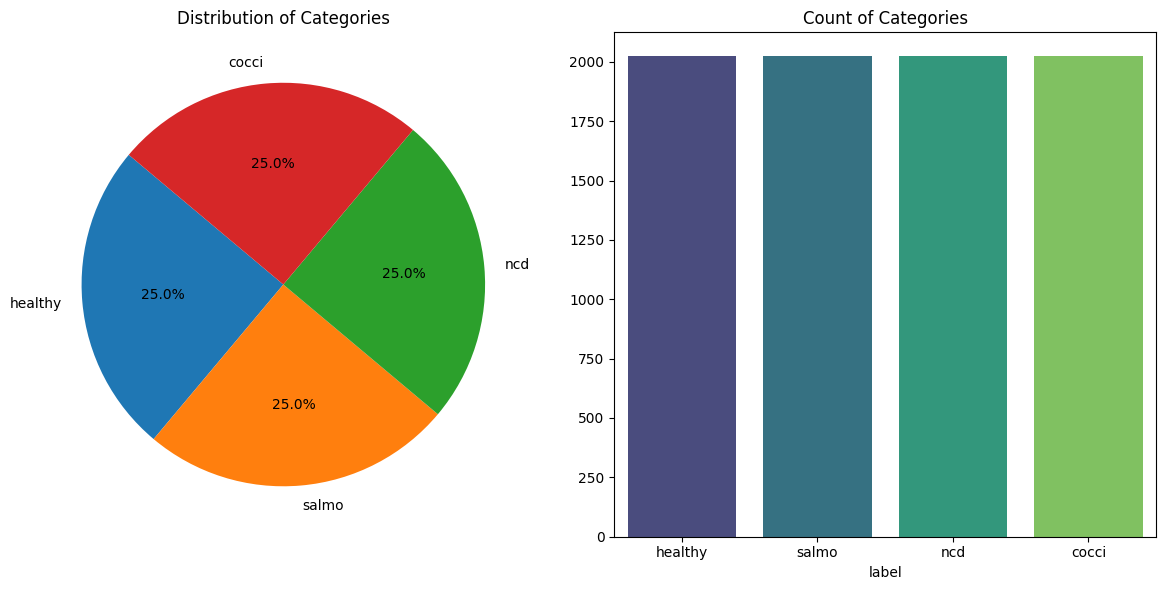

In [ ]:
# Count the occurrences of each category in the 'category' column
count = train_df['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
BATCH_SIZE=32

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255,)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow images from dataframes and apply augmentation (if any)
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, and used in training data
    class_mode='sparse'
)

print("Validation Data")
validation_ds = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, not used in validation
    shuffle=False,
    # class_mode='categorical',
    class_mode='sparse'
)

print("Test Data")
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    # Shuffle is default True, not used in test
    shuffle=False,
    # class_mode='categorical',
    class_mode='sparse'
)

Training Data
Found 8092 validated image filenames belonging to 4 classes.
Validation Data
Found 2024 validated image filenames belonging to 4 classes.
Test Data
Found 1124 validated image filenames belonging to 4 classes.


In [ ]:
# Get the class indices assigned by the generators
class_indices_train = train_ds.class_indices

# Print the class indices
print("Class indices for Training Data:", class_indices_train)

Class indices for Training Data: {'cocci': 0, 'healthy': 1, 'ncd': 2, 'salmo': 3}


In [ ]:
# Count occurrences of each class in training data
train_class_counts = Counter(train_ds.classes)
print("Training class distribution:", train_class_counts)

# Count occurrences of each class in validation data
val_class_counts = Counter(validation_ds.classes)
print("Validation class distribution:", val_class_counts)

# Count occurrences of each class in test data
test_class_counts = Counter(test_ds.classes)
print("Validation class distribution:", test_class_counts)

Training class distribution: Counter({1: 2023, 3: 2023, 2: 2023, 0: 2023})
Validation class distribution: Counter({1: 506, 0: 506, 3: 506, 2: 506})
Validation class distribution: Counter({3: 281, 2: 281, 1: 281, 0: 281})


In [ ]:
# Define the model save path
model_save_path = 'ensemble_model_best_30_epoch.keras'

# # Delete the file if it exists
# if os.path.exists(model_save_path):
#     try:
#         os.remove(model_save_path)
#         print(f"Existing '{model_save_path}' file deleted.")
#     except OSError as e:
#         print(f"Error deleting file: {e}")
#         # Handle the error, maybe ask the user to close any program using the file

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False),
    CSVLogger('training_log_30_epoch.csv', append=True)
]

# Train the ensemble model
history = ensemble_model.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    validation_data=validation_ds,
    validation_steps=validation_ds.samples // validation_ds.batch_size,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
252/252 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9789
Epoch 1: val_loss improved from inf to 0.08483, saving model to ensemble_model_best_10_epoch.keras


/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


252/252 [==============================] - 442s 757ms/step - loss: 0.0743 - accuracy: 0.9789 - val_loss: 0.0848 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 2/30
252/252 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9857
Epoch 2: val_loss improved from 0.08483 to 0.08321, saving model to ensemble_model_best_10_epoch.keras
252/252 [==============================] - 179s 710ms/step - loss: 0.0529 - accuracy: 0.9857 - val_loss: 0.0832 - val_accuracy: 0.9732 - lr: 1.0000e-04
Epoch 3/30
252/252 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9866
Epoch 3: val_loss did not improve from 0.08321
252/252 [==============================] - 172s 681ms/step - loss: 0.0447 - accuracy: 0.9866 - val_loss: 0.0949 - val_accuracy: 0.9772 - lr: 1.0000e-04
Epoch 4/30
252/252 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9888
Epoch 4: val_loss did not improve from 0.08321
252/252 [==============================] - 173s 685ms/step 

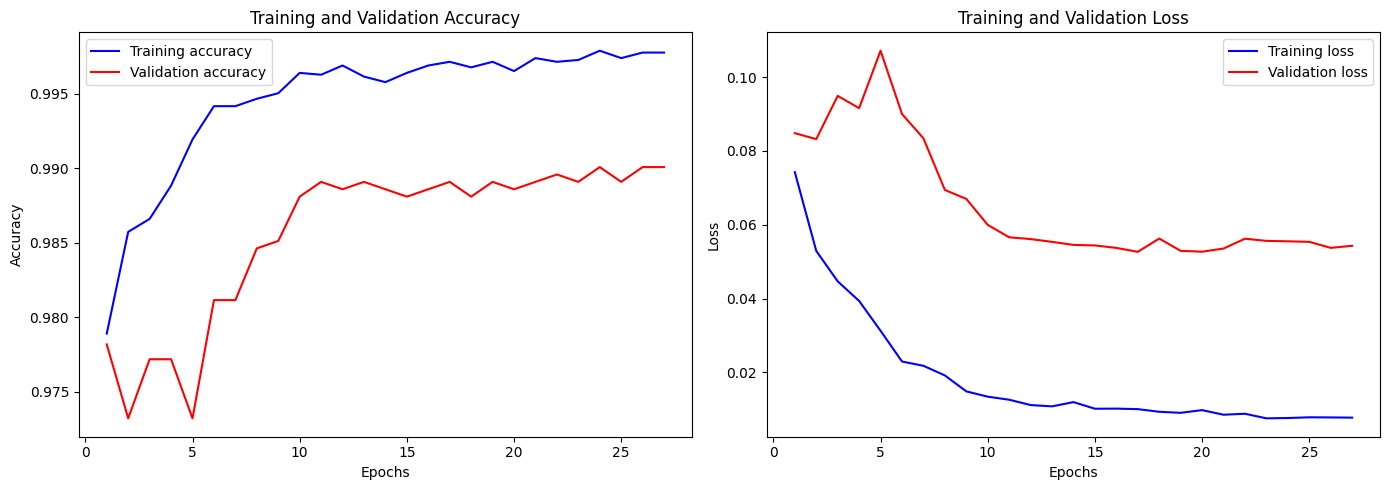

In [ ]:
# TODO: Plot the training and test loss curve - for 30 epochs
# Extract accuracy and loss data from history

# Plot history from csv
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history from CSV
# history.history = pd.read_csv('training_log_10_epoch.csv')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Import trained model and log csv from drive
!cp '/content/ensemble_model_best_30_epoch.keras' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/3_output/'
!cp '/content/training_log_30_epoch.csv' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/7_ensemble_avg_3_models_and_3_split/3_output/'

In [ ]:
# Import trained model and log csv from drive
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/3_output/ensemble_model_best_30_epoch.keras' -d '.'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/3_output/training_log_30_epoch.csv' -d '.'

In [ ]:
# Define the model save path
model_save_path = 'ensemble_model_best_30_epoch.keras'

# Local Model
loaded_model = ensemble_model

# Load the model
# loaded_model = load_model(model_save_path)


# Verify the model structure and summary
loaded_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 260, 260, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_1 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_2 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                           

In [ ]:
# # Manual Predict label
# def load_and_preprocess_image(image_path, target_size=(224, 224)):
#     # Load the image
#     img = load_img(image_path, target_size=target_size)
#     # Convert the image to an array
#     img_array = img_to_array(img)
#     # Expand dimensions to match the expected input shape for the model
#     img_array = np.expand_dims(img_array, axis=0)
#     # Normalize the image array
#     img_array /= 255.0
#     return img_array

# # Example usage
# image_class = 'healthy'
# image_number = '10'
# image_path = f'./dataset/{image_class}/{image_class}.{image_number}.jpg'
# preprocessed_image = load_and_preprocess_image(image_path)

# # Predict

# # Make a prediction
# predictions = loaded_model.predict(preprocessed_image)
# predicted_class = np.argmax(predictions, axis=1)

# # Optionally, map the predicted class to the class label
# class_labels = list(train_generator.class_indices.keys())
# predicted_label = class_labels[predicted_class[0]]

# print(f'Predicted class: {predicted_class[0]}')
# print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 32ms/step
Predicted class: 1
Predicted label: healthy


In [ ]:
# Evaluate the ensemble model - Validation Data
eval_results = loaded_model.evaluate(validation_ds, steps=validation_ds.samples // validation_ds.batch_size)
print(f'Validation loss: {eval_results[0]}')
print(f'Validation accuracy: {eval_results[1]}')

63/63 [==============================] - 9s 143ms/step - loss: 0.0527 - accuracy: 0.9891
Validation loss: 0.052683424204587936
Validation accuracy: 0.9890872836112976


In [ ]:
# Confusion Matrix - Validation Data
# Make predictions on validation data
validation_ds.reset()
predictions = ensemble_model.predict(validation_ds, steps=validation_ds.samples // validation_ds.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_ds.classes[:len(predicted_classes)]
class_labels = list(validation_ds.class_indices.keys())

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

63/63 [==============================] - 15s 136ms/step
Precision: 0.989114487340604
Recall: 0.9890873015873016
F1-score: 0.9890829980078678
Confusion Matrix:
 [[499   3   1   1]
 [  2 491   0  10]
 [  0   0 504   0]
 [  0   4   1 500]]


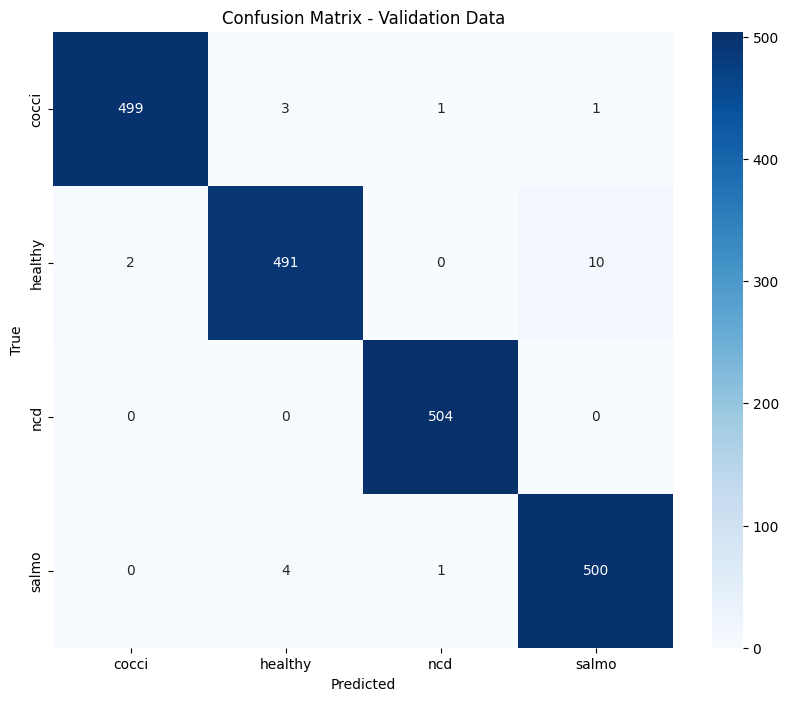

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_ds.class_indices.keys(), yticklabels=validation_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()


In [ ]:
# Evaluate the ensemble model - Test Data
eval_results = loaded_model.evaluate(test_ds, steps=test_ds.samples // test_ds.batch_size)
print(f'Test loss: {eval_results[0]}')
print(f'Test accuracy: {eval_results[1]}')

35/35 [==============================] - 5s 145ms/step - loss: 0.0783 - accuracy: 0.9893
Test loss: 0.07828062772750854
Test accuracy: 0.9892857074737549


In [ ]:
# Confusion Matrix - Test Data
# Make predictions on test data
test_ds.reset()
predictions = ensemble_model.predict(test_ds, steps=test_ds.samples // test_ds.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_ds.classes[:len(predicted_classes)]
class_labels = list(test_ds.class_indices.keys())

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

35/35 [==============================] - 5s 135ms/step
Precision: 0.9892982427471103
Recall: 0.9892857142857143
F1-score: 0.9892856802418476
Confusion Matrix:
 [[277   4   0   0]
 [  2 273   0   4]
 [  0   0 280   0]
 [  0   2   0 278]]


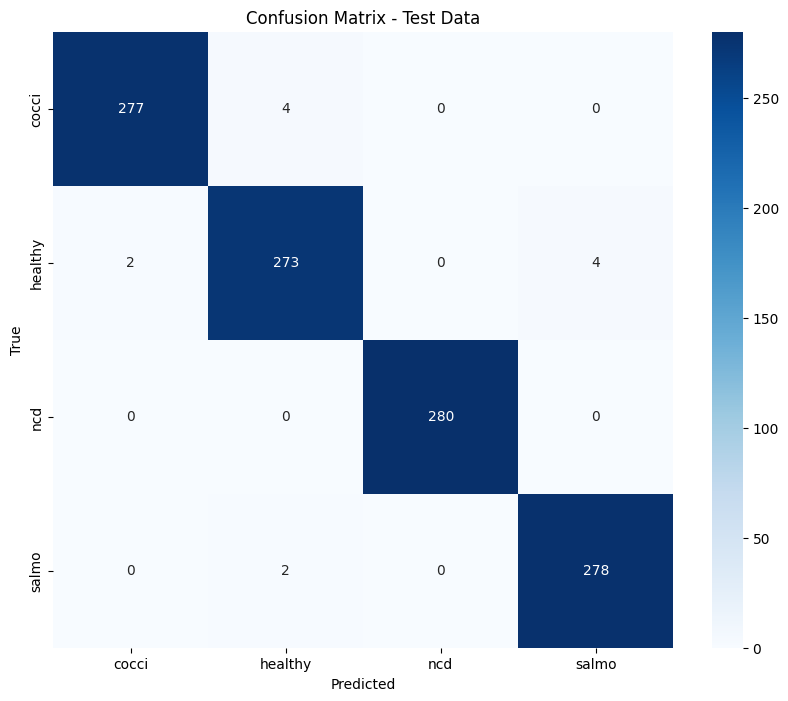

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_indices.keys(), yticklabels=test_ds.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data')
plt.show()
